# Modelo B para clasificación de imagenes

#### Jeffrey Daniel Leiva Cascante 2021016720
#### Richard Osvaldo León Chinchilla carnet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchsummary import summary


In [2]:
from google.colab import drive
drive.mount('/content/drive')
torch.cuda.is_available()

Mounted at /content/drive


False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Propuesta de modelo 1

Para la propuesta #1 del modelo B tenemos la siguiente arquitectura:

La primera capa es una capa de convolución de dos dimensiones que recibe la imágen de 1 canal (en escala de grises), aplica 64 filtros con tamaño de kernel 3 y padding de 1, lo que da como resultado la salida de 128x128x64.

La segunda capa aplica max pooling con un kernel de 2 y stride de 2, lo que produce una salida de 64x64x64.

Seguido de esto se tiene el módulo de Inception, que aplica varias operaciones de convolución y pooling en paralelo, lo que permite que el modelo aprenda mejor las características a diferentes niveles de complejidad. Cuenta con 4 ramas, en las que se aplican diversos tamaños de kernels y la salida de las ramas es de 64x64x128. Todas estas se concatenan y su salida es de 64x64x512.

Después se vuelve a aplicar max pooling con kernel de 2 y stride de 2, lo que da cómo resultado una salida de 32x32x512, se hace el flatten de la misma y esta es la entrada de la primera capa fully connected, la cual produce 128 canales de salida. La última capa tiene 128 canales de entrada y 3 de salida correspondientes a las tres categorías de imagenes.

Se utiliza reLU cómo función de activación para las capas convolucionales

In [15]:
class InceptionModuleOne(nn.Module):
  def __init__(self, chanels):
    super(InceptionModuleOne, self).__init__()

    self.branch1 = nn.Conv2d(chanels, 128, kernel_size=1)

    self.branch2 = nn.Sequential(
        nn.Conv2d(chanels, 128, kernel_size=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU()
    )

    self.branch3 = nn.Sequential(
        nn.Conv2d(chanels, 128, kernel_size=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=5, padding=2),
        nn.ReLU(),
    )

    self.branch4 = nn.Sequential(
        nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
        nn.Conv2d(chanels, 128, kernel_size=1),
        nn.ReLU(),
    )

  def forward(self,x):
    branch1 = F.relu(self.branch1(x))
    branch2 = self.branch2(x)
    branch3 = self.branch3(x)
    branch4 = self.branch4(x)
    return torch.cat([branch1, branch2, branch3, branch4],1)


class CNNModelBOne(nn.Module):
  def __init__(self):
    super(CNNModelBOne, self).__init__()
    self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.inception = InceptionModuleOne(64)
    self.dropout = nn.Dropout(0.2)
    self.fc1 = nn.Linear(512 *32 *32, 128)
    self.fc2 = nn.Linear(128 , 3)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = self.inception(x)
    x = self.pool(x)
    x = self.dropout(x)
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x



### Carga de datos y transformers de los datos

In [4]:
train_data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionar a 128x128
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises
    transforms.RandomRotation(20),  # Rotación aleatoria
    transforms.RandomHorizontalFlip(),  # Inversión horizontal aleatoria
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Variación de brillo y contraste
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalización
])


test_data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionar a 128x128
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises
    transforms.ToTensor(),   # Convertir a tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalización
])


# Definir las rutas a las carpetas
train_dir = './drive/MyDrive/Covid19-dataset/train'
test_dir = './drive/MyDrive/Covid19-dataset/test'

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_data_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_data_transforms)

# Definir el tamaño del subconjunto que quieres usar
subset_size = 0.2  # Por ejemplo, usar el 20% de los datos

# Obtener los índices aleatorios para el subconjunto del conjunto de entrenamiento
np.random.seed(42)
train_size = len(train_dataset)
indices = list(range(train_size))
np.random.shuffle(indices)  # Mezclar los índices

subset_indices = indices[:int(subset_size * train_size)]  # Obtener el subconjunto

# Crear un SubsetRandomSampler con los índices seleccionados
train_sampler = SubsetRandomSampler(subset_indices)

# Obtener los índices aleatorios para el subconjunto del conjunto de testing
test_size = len(test_dataset)
indices_test = list(range(test_size))
np.random.shuffle(indices_test)  # Mezclar los índices

subset_indices_test = indices_test[:int(subset_size * test_size)]  # Obtener el subconjunto

# Crear un SubsetRandomSampler con los índices seleccionados
test_sampler = SubsetRandomSampler(subset_indices_test)

# Definir DataLoader para el conjunto de entrenamiento con el subconjunto de datos
train_loader = DataLoader(train_dataset, batch_size=8, sampler=train_sampler)

# También puedes crear un DataLoader para el conjunto de prueba completo
test_loader = DataLoader(test_dataset, batch_size=8, sampler=test_sampler)


### Proof of Concept Modelo 1

In [36]:

model = CNNModelBOne()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Definir la función de entrenamiento
def train_model_with_subset(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()  # Poner el modelo en modo de entrenamiento

        running_loss = 0.0
        correct = 0
        total = 0

        # Training
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Limpiar los gradientes
            outputs = model(inputs)  # Hacer una predicción
            loss = criterion(outputs, labels)  # Calcular la pérdida
            loss.backward()  # Hacer backpropagation
            optimizer.step()  # Actualizar los pesos

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():  # Disable gradients for validation
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_running_loss / len(test_loader)
        val_accuracy = 100 * val_correct / val_total

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Train the model with validation
train_model_with_subset(model, train_loader, test_loader, criterion, optimizer, epochs=50)





Epoch 1/50, Train Loss: 1.1141, Train Accuracy: 48.00%, Val Loss: 0.9706, Val Accuracy: 53.85%
Epoch 2/50, Train Loss: 1.0273, Train Accuracy: 36.00%, Val Loss: 1.1734, Val Accuracy: 46.15%
Epoch 3/50, Train Loss: 0.8629, Train Accuracy: 68.00%, Val Loss: 0.8886, Val Accuracy: 69.23%
Epoch 4/50, Train Loss: 0.8075, Train Accuracy: 58.00%, Val Loss: 0.8434, Val Accuracy: 46.15%
Epoch 5/50, Train Loss: 0.5840, Train Accuracy: 74.00%, Val Loss: 1.1714, Val Accuracy: 46.15%
Epoch 6/50, Train Loss: 0.5803, Train Accuracy: 76.00%, Val Loss: 0.7456, Val Accuracy: 61.54%
Epoch 7/50, Train Loss: 0.4981, Train Accuracy: 82.00%, Val Loss: 0.9653, Val Accuracy: 46.15%
Epoch 8/50, Train Loss: 0.4062, Train Accuracy: 86.00%, Val Loss: 0.7758, Val Accuracy: 69.23%
Epoch 9/50, Train Loss: 0.3610, Train Accuracy: 86.00%, Val Loss: 0.7158, Val Accuracy: 69.23%
Epoch 10/50, Train Loss: 0.2927, Train Accuracy: 88.00%, Val Loss: 0.9219, Val Accuracy: 61.54%
Epoch 11/50, Train Loss: 0.2829, Train Accuracy: 

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}
{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}
tensor([2, 1, 1, 2, 2, 1, 2, 1])


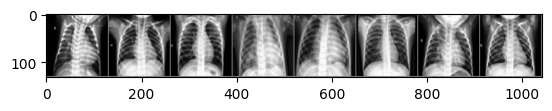

GroundTruth
Viral Pneumonia
Normal
Normal
Viral Pneumonia
Viral Pneumonia
Normal
Viral Pneumonia
Normal


In [9]:
classes = ('Covid', 'Normal','Viral Pneumonia')

#Para ver com se asignan las etiquetas a cada clase en el set de training
print(train_dataset.class_to_idx)
#Lo mismo pero para el set de testing
print(test_dataset.class_to_idx)

dataiter = iter(test_loader)
images, labels = next(dataiter)

print(labels)

def imshow(img):
    # Desnormalizar: (img * std) + mean
    img = img * 0.5 + 0.5  # Desnormalizar usando mean=0.5 y std=0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')  # Añadir cmap si es necesario
    plt.show()

imshow(torchvision.utils.make_grid(images))

print('GroundTruth')
for j in range(8):
    print(f'{classes[labels[j]]:5s}')

In [10]:
images = images.to(device)  # Mueve las imágenes a la GPU si está disponible

outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ')

for j in range(8):
    print(f'{classes[predicted[j]]:5s}')


Predicted: 
Viral Pneumonia
Viral Pneumonia
Viral Pneumonia
Viral Pneumonia
Viral Pneumonia
Normal
Viral Pneumonia
Viral Pneumonia


In [40]:
correct = 0
total = 0
# debido a que no estamos entrenando, no necesitamos calcular los gradientes para las salidas
with torch.no_grad():
    for data in test_loader:
        images, labels = images.to(device), labels.to(device)
        # calcular outputs corriendo imagenes en la red
        outputs = model(images)
        # La clase con mayor valor es la que escogemos como salida
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy de la red en las 23 imagenes de test: {100 * correct // total} %')

Accuracy de la red en las 23 imagenes de test: 75 %


## Propuesta de modelo 2

In [24]:
class InceptionModuleTwo(nn.Module):
  def __init__(self, chanels):
    super(InceptionModuleTwo, self).__init__()

    self.branch1 = nn.Conv2d(chanels, 32, kernel_size=1)

    self.branch2 = nn.Sequential(
        nn.Conv2d(chanels, 32, kernel_size=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU()
    )

    self.branch3 = nn.Sequential(
        nn.Conv2d(chanels, 32, kernel_size=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=5, padding=2),
        nn.ReLU(),
    )

    self.branch4 = nn.Sequential(
        nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
        nn.Conv2d(chanels, 32, kernel_size=1),
        nn.ReLU(),
    )

  def forward(self,x):
    branch1 = F.relu(self.branch1(x))
    branch2 = self.branch2(x)
    branch3 = self.branch3(x)
    branch4 = self.branch4(x)
    return torch.cat([branch1, branch2, branch3, branch4],1)


class CNNModelBTwo(nn.Module):
    def __init__(self):
        super(CNNModelBTwo, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32,64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.2)


        self.inception = InceptionModuleTwo(64)

        self.conv3 = nn.Conv2d(192, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(16 * 16 * 256, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)

        x = self.inception(x)

        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        x = self.dropout2(x)
        x = torch.flatten(x,1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))



        x = self.fc3(x)
        return x






#### Proof of Concept modelo 2

In [25]:

model = CNNModelBTwo()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir la función de entrenamiento
def train_model_with_subset(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()  # Poner el modelo en modo de entrenamiento

        running_loss = 0.0
        correct = 0
        total = 0

        # Training
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Limpiar los gradientes
            outputs = model(inputs)  # Hacer una predicción
            loss = criterion(outputs, labels)  # Calcular la pérdida
            loss.backward()  # Hacer backpropagation
            optimizer.step()  # Actualizar los pesos

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():  # Disable gradients for validation
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_running_loss / len(test_loader)
        val_accuracy = 100 * val_correct / val_total

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Train the model with validation
train_model_with_subset(model, train_loader, test_loader, criterion, optimizer, epochs=50)





Epoch 1/50, Train Loss: 1.5904, Train Accuracy: 38.00%, Val Loss: 1.0884, Val Accuracy: 46.15%
Epoch 2/50, Train Loss: 1.1085, Train Accuracy: 30.00%, Val Loss: 1.1144, Val Accuracy: 23.08%
Epoch 3/50, Train Loss: 1.0868, Train Accuracy: 46.00%, Val Loss: 1.2000, Val Accuracy: 23.08%
Epoch 4/50, Train Loss: 1.0518, Train Accuracy: 46.00%, Val Loss: 1.2501, Val Accuracy: 23.08%
Epoch 5/50, Train Loss: 1.0891, Train Accuracy: 46.00%, Val Loss: 1.2541, Val Accuracy: 23.08%
Epoch 6/50, Train Loss: 1.0898, Train Accuracy: 46.00%, Val Loss: 1.1586, Val Accuracy: 23.08%
Epoch 7/50, Train Loss: 1.0692, Train Accuracy: 46.00%, Val Loss: 1.1316, Val Accuracy: 23.08%
Epoch 8/50, Train Loss: 1.0507, Train Accuracy: 46.00%, Val Loss: 1.1366, Val Accuracy: 23.08%
Epoch 9/50, Train Loss: 0.9052, Train Accuracy: 62.00%, Val Loss: 0.8977, Val Accuracy: 53.85%
Epoch 10/50, Train Loss: 0.6928, Train Accuracy: 76.00%, Val Loss: 0.5506, Val Accuracy: 84.62%
Epoch 11/50, Train Loss: 0.8224, Train Accuracy: 

In [27]:
correct = 0
total = 0
# debido a que no estamos entrenando, no necesitamos calcular los gradientes para las salidas
with torch.no_grad():
    for data in test_loader:
        images, labels = images.to(device), labels.to(device)
        # calcular outputs corriendo imagenes en la red
        outputs = model(images)
        # La clase con mayor valor es la que escogemos como salida
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy de la red en las 8 imagenes de test: {100 * correct // total} %')

Accuracy de la red en las 8 imagenes de test: 62 %


In [ ]:
torch.cuda.empty_cache()

### Propuesta de modelo 3

In [46]:
class InceptionModuleThree(nn.Module):
  def __init__(self, chanels):
    super(InceptionModuleThree, self).__init__()

    self.branch1 = nn.Sequential(
        nn.Conv2d(chanels, 32, kernel_size=1),
        nn.BatchNorm2d(32),
        nn.ReLU()
    )

    self.branch2 = nn.Sequential(
        nn.Conv2d(chanels, 32, kernel_size=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )

    self.branch3 = nn.Sequential(
        nn.Conv2d(chanels, 32, kernel_size=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=5, padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
    )

    self.branch4 = nn.Sequential(
        nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
        nn.Conv2d(chanels, 32, kernel_size=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
    )

  def forward(self,x):
    branch1 = self.branch1(x)
    branch2 = self.branch2(x)
    branch3 = self.branch3(x)
    branch4 = self.branch4(x)
    return torch.cat([branch1, branch2, branch3, branch4],1)


class CNNModelBThree(nn.Module):
    def __init__(self):
        super(CNNModelBThree, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),  # Batch normalization
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # Batch normalization
            nn.ReLU()
        )

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.2)

        self.inception = InceptionModuleThree(64)

        self.conv3 = nn.Sequential(
            nn.Conv2d(192, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  # Batch normalization
            nn.ReLU()
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  # Batch normalization
            nn.ReLU()
        )

        self.dropout2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(32 * 32 * 256, 512)
        self.dropout_fc = nn.Dropout(0.4)  # Add dropout here as well
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(self.conv2(x))
        x = self.dropout1(x)

        x = self.inception(x)

        x = self.pool(self.conv3(x))
        x = self.conv4(x)

        x = self.dropout2(x)
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [47]:

model = CNNModelBThree()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir la función de entrenamiento
def train_model_with_subset(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()  # Poner el modelo en modo de entrenamiento

        running_loss = 0.0
        correct = 0
        total = 0

        # Training
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Limpiar los gradientes
            outputs = model(inputs)  # Hacer una predicción
            loss = criterion(outputs, labels)  # Calcular la pérdida
            loss.backward()  # Hacer backpropagation
            optimizer.step()  # Actualizar los pesos

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():  # Disable gradients for validation
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_running_loss / len(test_loader)
        val_accuracy = 100 * val_correct / val_total

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Train the model with validation
train_model_with_subset(model, train_loader, test_loader, criterion, optimizer, epochs=50)





Epoch 1/50, Train Loss: 16.4037, Train Accuracy: 34.00%, Val Loss: 9.3346, Val Accuracy: 23.08%
Epoch 2/50, Train Loss: 3.6775, Train Accuracy: 46.00%, Val Loss: 14.4478, Val Accuracy: 23.08%
Epoch 3/50, Train Loss: 4.4475, Train Accuracy: 50.00%, Val Loss: 8.9487, Val Accuracy: 23.08%
Epoch 4/50, Train Loss: 1.0940, Train Accuracy: 56.00%, Val Loss: 8.5910, Val Accuracy: 23.08%
Epoch 5/50, Train Loss: 1.5929, Train Accuracy: 58.00%, Val Loss: 2.0045, Val Accuracy: 30.77%
Epoch 6/50, Train Loss: 0.9931, Train Accuracy: 70.00%, Val Loss: 3.2039, Val Accuracy: 53.85%
Epoch 7/50, Train Loss: 0.6443, Train Accuracy: 78.00%, Val Loss: 1.0489, Val Accuracy: 69.23%
Epoch 8/50, Train Loss: 1.0672, Train Accuracy: 74.00%, Val Loss: 2.3342, Val Accuracy: 53.85%
Epoch 9/50, Train Loss: 0.4067, Train Accuracy: 86.00%, Val Loss: 0.5345, Val Accuracy: 76.92%
Epoch 10/50, Train Loss: 0.3293, Train Accuracy: 86.00%, Val Loss: 1.2463, Val Accuracy: 53.85%
Epoch 11/50, Train Loss: 0.7576, Train Accuracy

In [48]:
correct = 0
total = 0
# debido a que no estamos entrenando, no necesitamos calcular los gradientes para las salidas
with torch.no_grad():
    for data in test_loader:
        images, labels = images.to(device), labels.to(device)
        # calcular outputs corriendo imagenes en la red
        outputs = model(images)
        # La clase con mayor valor es la que escogemos como salida
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy de la red en las 8 imagenes de test: {100 * correct // total} %')

Accuracy de la red en las 8 imagenes de test: 75 %
